In [1]:
!pip install optuna

[I 2025-04-19 22:32:11,937] A new study created in memory with name: no-name-e3ee154c-225e-4fd9-ac84-0270bbdc121d
[I 2025-04-19 22:32:12,062] Trial 0 finished with value: 0.43333333333333335 and parameters: {'kernel': 'sigmoid', 'C': 0.003820895305705753, 'gamma': 0.027640749463679223, 'coef0': -0.23817720691050792}. Best is trial 0 with value: 0.43333333333333335.
[I 2025-04-19 22:32:12,119] Trial 1 finished with value: 0.2791666666666667 and parameters: {'kernel': 'poly', 'C': 103.95260781702396, 'gamma': 0.05000805959448377, 'degree': 4, 'coef0': -0.026989013468127432}. Best is trial 0 with value: 0.43333333333333335.


Dataset Shape: (1599, 12)


[I 2025-04-19 22:32:12,170] Trial 2 finished with value: 0.5854166666666667 and parameters: {'kernel': 'linear', 'C': 0.0016362258585215892}. Best is trial 2 with value: 0.5854166666666667.
[I 2025-04-19 22:32:12,283] Trial 3 finished with value: 0.6041666666666666 and parameters: {'kernel': 'rbf', 'C': 2.0027631044897833, 'gamma': 0.001325576608249895}. Best is trial 3 with value: 0.6041666666666666.
[I 2025-04-19 22:32:12,355] Trial 4 finished with value: 0.43333333333333335 and parameters: {'kernel': 'poly', 'C': 0.21849295366662172, 'gamma': 0.00011679854216640768, 'degree': 5, 'coef0': -0.46639205672147366}. Best is trial 3 with value: 0.6041666666666666.
[I 2025-04-19 22:32:12,430] Trial 5 finished with value: 0.43333333333333335 and parameters: {'kernel': 'poly', 'C': 0.001229179539482316, 'gamma': 0.0007966541247997702, 'degree': 3, 'coef0': 0.5881622752766948}. Best is trial 3 with value: 0.6041666666666666.
[I 2025-04-19 22:32:12,565] Trial 6 finished with value: 0.6145833333


Optimization Results:
Sample  Best Accuracy                     Best SVM Parameters
    S1          63.33  kernel: rbf, C: 19.1183, gamma: 0.9976
    S2          64.79   kernel: rbf, C: 2.0233, gamma: 0.9098
    S3          64.58   kernel: rbf, C: 1.5701, gamma: 0.3941
    S4          67.92  kernel: rbf, C: 79.1232, gamma: 0.7411
    S5          64.38   kernel: rbf, C: 7.4281, gamma: 0.6355
    S6          67.29   kernel: rbf, C: 1.6157, gamma: 0.4394
    S7          63.12 kernel: rbf, C: 299.7926, gamma: 0.0023
    S8          65.83 kernel: rbf, C: 167.8196, gamma: 0.8289
    S9          63.75 kernel: rbf, C: 156.1858, gamma: 0.0021
   S10          68.54   kernel: rbf, C: 0.8317, gamma: 0.8070

Results saved to 'svm_optimization_results.csv'


C:\Users\aryan\AppData\Local\Temp\ipykernel_6012\1973827867.py:84: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(best_study)


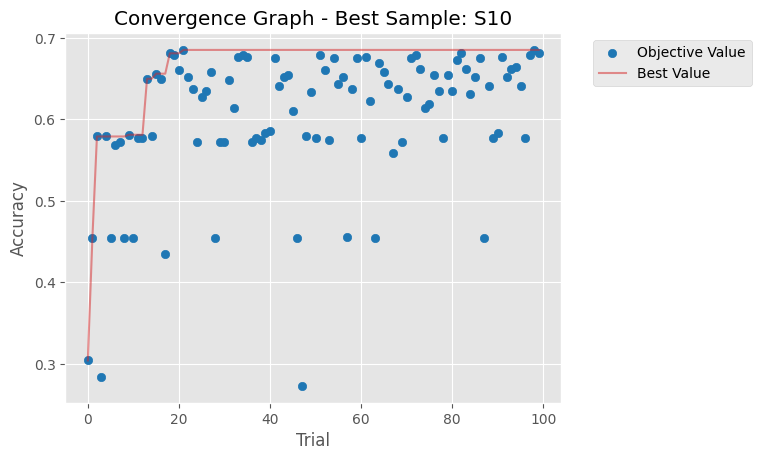

Convergence plot saved as 'convergence_plot.png'


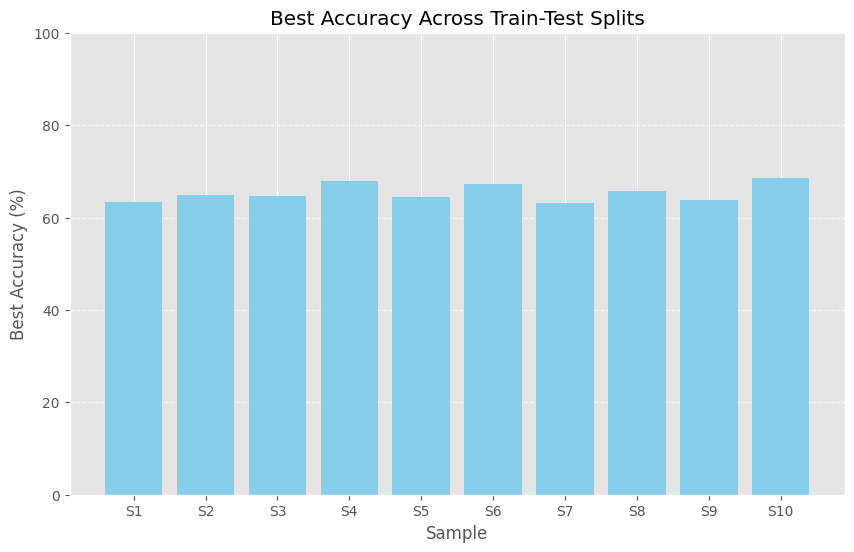

Accuracy bar plot saved as 'accuracy_bar_plot.png'


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna
import matplotlib.pyplot as plt

# 1. Load UCI Wine Quality dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')

X = df.drop("quality", axis=1)
y = df["quality"]

print("Dataset Shape:", df.shape)

# Store results
results = []
study_convergence = {}

# 2. Generate 10 different train-test splits
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    def objective(trial):
        # Adjusted hyperparameter ranges
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
        C = trial.suggest_float("C", 1e-3, 1e3, log=True)  # Wider range for C
        gamma = "scale"  # Default value
        if kernel in ["rbf", "poly", "sigmoid"]:
            gamma = trial.suggest_float("gamma", 1e-5, 1, log=True)  # Wider range for gamma
        degree = 3  # Default value
        if kernel == "poly":
            degree = trial.suggest_int("degree", 1, 5)  # Range for polynomial degree
        coef0 = 0.0  # Default value
        if kernel in ["poly", "sigmoid"]:
            coef0 = trial.suggest_float("coef0", -1, 1)  # Range for coef0

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=coef0))
        ])

        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_accuracy = study.best_value

    # Format best parameters as a string
    best_params_str = ", ".join([f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" 
                                 for k, v in best_params.items()])

    results.append({
        "Sample": f"S{i+1}",
        "Best Accuracy": round(best_accuracy * 100, 2),
        "Best SVM Parameters": best_params_str
    })

    # Store study for convergence plot
    study_convergence[f"S{i+1}"] = study

# 3. Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nOptimization Results:")
print(results_df.to_string(index=False))  # Nicely formatted table

# 4. Save results to CSV
results_df.to_csv("svm_optimization_results.csv", index=False)
print("\nResults saved to 'svm_optimization_results.csv'")

# 5. Find best sample for plotting convergence
best_sample_index = np.argmax(results_df["Best Accuracy"])
best_sample_key = f"S{best_sample_index+1}"
best_study = study_convergence[best_sample_key]

# 6. Plot and save convergence graph
optuna.visualization.matplotlib.plot_optimization_history(best_study)
plt.title(f"Convergence Graph - Best Sample: {best_sample_key}")
plt.ylabel("Accuracy")
plt.xlabel("Trial")
plt.grid(True)
plt.savefig("convergence_plot.png", dpi=300, bbox_inches="tight")
plt.show()
print("Convergence plot saved as 'convergence_plot.png'")

# 7. Plot and save bar chart of accuracies
plt.figure(figsize=(10, 6))
plt.bar(results_df["Sample"], results_df["Best Accuracy"], color='skyblue')
plt.xlabel("Sample")
plt.ylabel("Best Accuracy (%)")
plt.title("Best Accuracy Across Train-Test Splits")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.savefig("accuracy_bar_plot.png", dpi=300, bbox_inches="tight")
plt.show()
print("Accuracy bar plot saved as 'accuracy_bar_plot.png'")